In [1]:
import os
import random
from solve import Formula

In [2]:
def create_random_config(number_of_variables):
    config = []
    for _ in range(number_of_variables):
        if random.random() < 0.5:
            config.append(1)
        else:
            config.append(0)
    return config

In [3]:
filename = os.path.join(os.getcwd(), "data", "wuf20-71-M", "wuf20-01.mwcnf")
formula = Formula(filename)
variable_configuration = create_random_config(formula.number_of_variables)
print(formula)
print("Assignment: ", variable_configuration)

Clauses: [[4, -18, 19], [3, 18, -5], [-5, -8, -15], [-20, 7, -16], [10, -13, -7], [-12, -9, 17], [17, 19, 5], [-16, 9, 15], [11, -5, -14], [-18, 14, 1], [-19, -15, 10], [-8, 4, 7], [7, 17, -15], [12, -7, -14], [2, -15, -11], [9, 6, 1], [9, -15, 13], [12, -7, -17], [-18, -2, 20], [20, 12, 4], [-16, 18, -4], [-13, 15, 10], [12, -14, -7], [-7, 16, 10], [6, 10, 7], [20, 14, -16], [-19, 17, 11], [-7, 1, -20], [-5, 12, 15], [12, -11, -7], [-5, 19, -8], [1, 16, 17], [20, -14, -15], [13, -4, 10], [14, 7, 10], [-5, 9, 20], [10, 1, -19], [-16, -15, -1], [-15, -10, 4], [4, -15, -3], [-10, -16, 11], [-8, 12, -5], [14, -6, 12], [1, 6, 11], [-13, -5, -1], [-7, -2, 12], [1, -20, 19], [-2, -13, -8], [-11, 14, 9], [-6, -15, -2], [5, -12, -15], [-6, 17, 5], [-5, 19, -18], [-18, 14, -4], [9, -5, -1], [10, -19, -14], [20, 9, 4], [-5, 13, -17], [-18, 3, 11], [7, -9, 17], [-15, -6, -3], [-2, 3, -13], [12, 3, -2], [-2, -3, 17], [20, -15, -16], [-5, -17, -19], [-20, -18, 11], [-9, 1, -5], [-19, 9, 17], [12, -

In [4]:
# import visualization libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


ModuleNotFoundError: No module named 'seaborn'

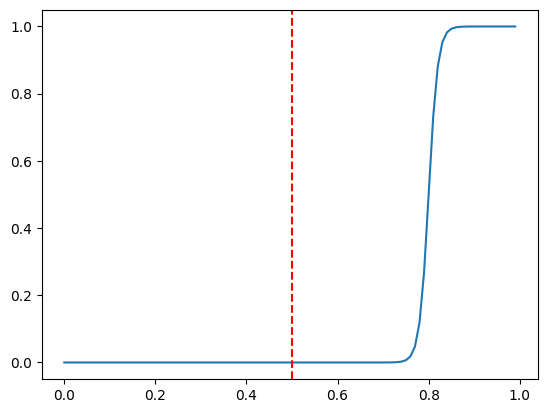

In [36]:
import math

steepness_param = 100
midpoint_curve = 0.8
# plot logistic function
# success_ratio = 1 / (1 + math.exp(-steepness_param * (x - midpoint_curve)))

def f(x):
    return 1 / (1 + math.exp(-steepness_param * (x - midpoint_curve)))

datay = [ f(x) for x in np.arange(0, 1, 0.01)]
datax = [ x for x in np.arange(0, 1, 0.01)]

plt.ion()
plt.plot(datax, datay)
# make a vertical line in the plot
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()


In [37]:
for i in np.arange(0.1, 1.0, 0.01):
    print(f(i))

3.975449735908647e-31
1.0806392777072785e-30
2.9374821117108028e-30
7.984904245686979e-30
2.1705220113036392e-29
5.900090541596978e-29
1.603810890548615e-28
4.359610000063019e-28
1.1850648642339641e-27
3.2213402859924933e-27
8.756510762696457e-27
2.3802664086943834e-26
6.470234925645414e-26
1.758792202424299e-25
4.780892883885435e-25
1.2995814250074846e-24
3.5326285722007564e-24
9.602680054508539e-24
2.6102790696676677e-23
7.095474162284604e-23
1.9287498479638903e-22
5.242885663363427e-22
1.4251640827409148e-21
3.873997628687105e-21
1.0530617357553588e-20
2.8625185805493533e-20
7.781132241133686e-20
2.1151310375910504e-19
5.749522264293478e-19
1.5628821893349666e-18
4.248354255291499e-18
1.154822417301554e-17
3.1391327920479624e-17
8.533047625743882e-17
2.3195228302435193e-16
6.305116760146851e-16
1.7139084315419734e-15
4.658886145103277e-15
1.2664165549093656e-14
3.44247710846976e-14
9.357622968839034e-14
2.543665647376213e-13
6.91440010693525e-13
1.879528816535504e-12
5.1090890280371